In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.autograd import *
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

from utils import * 
import sys

In [2]:
# Read Geant Dataset
data = read_geant_data()
start_idx = 0 
end_idx = int((60/15)*24*21) # three weeks of data (same number of samples as abilene for 1 week)
data = data[start_idx:end_idx]

# Train Test Split 
train_data, test_data = train_test_split(data, 0.8)

In [3]:
# Feature-wise min-max normalization (normalize each element over time)
min_vals_train = train_data.min(axis=0)  # Shape (144,)
max_vals_train = train_data.max(axis=0)  # Shape (144,)
train_data_norm = (train_data - min_vals_train) / (max_vals_train - min_vals_train + 1e-8)  # Avoid division by zero

# Feature-wise min-max normalization (normalize each element over time)
min_vals_test = test_data.min(axis=0)  # Shape (144,)
max_vals_test = test_data.max(axis=0)  # Shape (144,)
test_data_norm = (test_data - min_vals_test) / (max_vals_test - min_vals_test + 1e-8)  # Avoid division by zero

# Window the dataset
trainX, trainY= create_dataset(train_data_norm, 10) 
testX, testY = create_dataset(test_data_norm, 10)  

In [4]:
# Define hyper parameters 
input_size = 1  # Each feature is treated as an individual time series
hidden_size = 30
num_layers = 1
learn_rate = 0.001 
epochs = 100
batch_size = 32
num_features = 23 * 23  # Total number of features in the flattened traffic matrix
shuffle = False #don't want to lose the time dependency
num_workers = 0  # Number of subprocesses to use for data loading

In [5]:
# Create a separate model for each feature in the traffic matrix
models = [RNN(input_size, hidden_size, num_layers) for _ in range(num_features)]
optimizers = [optim.Adam(model.parameters(), lr=learn_rate) for model in models]
criterion = nn.MSELoss()

In [6]:
folder_name  = 'models_od\\'

for feature in range(num_features): 

    print('#####--training model %d--#####\n' % feature)
    
    # Get model and optimizer
    model = models[feature]
    optimizer = optimizers[feature]

    # Create training dataset and dataloader for current feature
    train_loader = get_dataloader(np.expand_dims(trainX[:, :, feature], axis = 2), np.expand_dims(trainY[:, feature], axis = 1),
                                   batch_size, num_workers, shuffle)
    
    # Train the model
    loss = train(model, train_loader, epochs, criterion, optimizer)

    # Save the model, we will get model outputs in a later loop
    model_name = 'model_%d.pth' % feature
    model_path = folder_name+model_name

    torch.save(model.state_dict(), model_path)

#####--training model 0--#####

-----Begin Training------
Epoch [10/100], Loss: 2.2278e-04
Epoch [20/100], Loss: 1.4211e-03
Epoch [30/100], Loss: 1.9306e-03
Epoch [40/100], Loss: 2.7916e-03
Epoch [50/100], Loss: 3.6398e-03
Epoch [60/100], Loss: 4.0653e-03
Epoch [70/100], Loss: 3.6213e-03
Epoch [80/100], Loss: 3.1896e-03
Epoch [90/100], Loss: 3.0066e-03
Epoch [100/100], Loss: 2.9712e-03
#####--training model 1--#####

-----Begin Training------
Epoch [10/100], Loss: 2.3607e-02
Epoch [20/100], Loss: 1.7870e-02
Epoch [30/100], Loss: 1.1440e-02
Epoch [40/100], Loss: 6.9626e-03
Epoch [50/100], Loss: 5.3262e-03
Epoch [60/100], Loss: 4.7486e-03
Epoch [70/100], Loss: 4.4519e-03
Epoch [80/100], Loss: 4.2378e-03
Epoch [90/100], Loss: 4.0588e-03
Epoch [100/100], Loss: 3.8988e-03
#####--training model 2--#####

-----Begin Training------
Epoch [10/100], Loss: 1.0468e-03
Epoch [20/100], Loss: 1.0840e-03
Epoch [30/100], Loss: 1.0944e-03
Epoch [40/100], Loss: 1.0948e-03
Epoch [50/100], Loss: 1.7449e-03

Test Models

In [11]:
predictions = np.zeros((test_data.shape[0]-10, test_data.shape[1]))
criterion = nn.MSELoss()

for i in range(529):
    path = 'models_od\\model_%d.pth' % i
    model = RNN(input_size, hidden_size, num_layers)
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()

    testX_i = np.expand_dims(testX[:, :, i], axis = 2)
    testY_i = np.expand_dims(testY[:, i], axis = 1)

    # Create test_loader
    test_loader = get_dataloader(testX_i, testY_i,
                                batch_size, num_workers, shuffle)

    total_loss = 0.0 

    model_outputs = [] # account for window size
    test_loss = np.zeros((testY_i.shape[0], 1))

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_loader): 
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            model_outputs.append(outputs.flatten())


    # Concatenate all outputs into a single tensor
    model_outputs =  torch.cat(model_outputs, dim=0).numpy()

    # Save the model_outputs
    np.save('model_outputs_od\\geant_local_mse_od_%i.npy' % i, 
        model_outputs)

    # Inverse normalize the prediction
    inverse_preds = model_outputs * (max_vals_test[i] - min_vals_test[i]) + min_vals_test[i]

    # Add inverse normalized predictions to largers matrix
    predictions[:, i] = inverse_preds


In [13]:
plot_and_save_heatmap(test_data/1e5, predictions/1e5, num_nodes=23, save_path = 'Figs\\heat_maps',
                          fig_name= 'inverse_normalized_model_predictions_local.png')

In [16]:
# Compute MCF on inverse normalized predictions
mlu_preds, Nans = mlu_on_preds(predictions, num_nodes=23, capacity = 1e7, topo='fc')

if Nans: 
    print('NaN values in mlu_preds, ending program')

# Save MLUs
np.save('mlu_baseline\\mlu_preds_geant_local_mse.npy', mlu_preds)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10


In [17]:
# Load MCF baseline on original dataset
mlu_gt = np.load('mlu_baseline\\mlu_baseline_geant_fc.npy')
mlu_gt = mlu_gt[len(train_data):]

In [18]:
# Plot mlu cdf and mlu comparison
plot_and_save_ecdf(mlu_gt, mlu_preds, save_path = 'Figs\\ecdfs', fig_name='CDF_mlu_geant_local_mse.png')
plot_and_save_mlu_compare(mlu_gt, mlu_preds, save_path='Figs\\mlu_compare', fig_name='mlu_compare_geant_local_mse.png')
plot_and_save_pdf(mlu_gt, mlu_preds, save_path = 'Figs\\pdfs', fig_name='PDF_mlu_geant_local_mse.png')

In [20]:
# plot all predictions
for i in range(144):
    plt.plot(test_data[10:, i], label = 'Original')
    plt.plot(predictions[:, i], label = 'Prediction')
    plt.xlabel('Time Index')
    plt.ylabel('Traffic Demand (bps)')
    plt.legend(loc = 'upper right')
    plt.savefig('Figs\\od_pairs\\prediction_local_%d.png' % i, dpi = 300, bbox_inches='tight')
    plt.close()

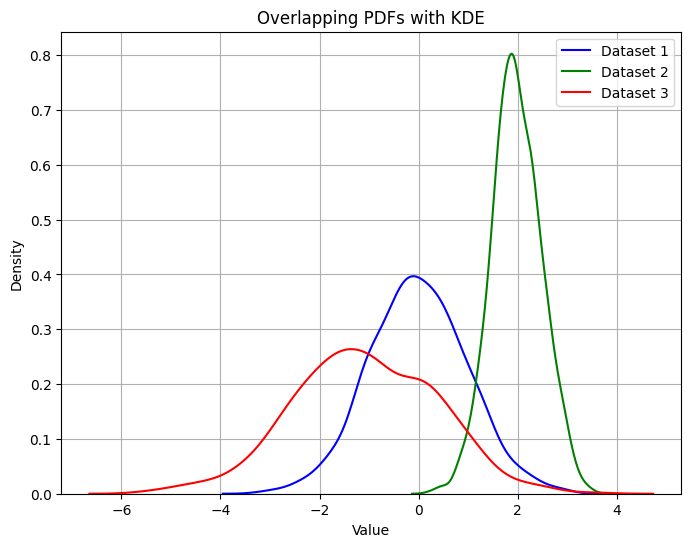

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(2, 0.5, 1000)
data3 = np.random.normal(-1, 1.5, 1000)

# Plot PDFs directly with seaborn
plt.figure(figsize=(8, 6))
sns.kdeplot(data1, label="Dataset 1", color="blue")
sns.kdeplot(data2, label="Dataset 2", color="green")
sns.kdeplot(data3, label="Dataset 3", color="red")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Overlapping PDFs with KDE")
plt.legend()
plt.grid()
plt.show()
